In [65]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

import torch
device = 'cpu'
from torchdiffeq import odeint

from matplotlib import rcParams
rcParams['figure.figsize'] = 12,8
plt.rc('font', size=16)

In [81]:
# Adapted from Matt Levine's GitHub at https://github.com/mattlevine22/contRNN
def L63_torch(t, S, sigma=10.0, rho=28.0, beta=8.0/3):
    """ Lorenz-63 dynamical model implemented for torch. """
    x_1 = sigma*(S[1]-S[0])
    x_2 = S[0]*(rho-S[2])-S[1]
    x_3 = S[0]*S[1] - beta*S[2]
    dS  = torch.hstack((x_1,x_2,x_3))
    return dS

def L63_torch_modified(t, S, eta, sigma=10.0, rho=28.0, beta=8.0/3):
    """ Lorenz-63 dynamical model with added terms implemented for torch. """
    x_1 = sigma*(S[1]-S[0])
    x_2 = S[0]*(rho-S[2])-S[1]
    x_3 = S[0]*S[1] - beta*S[2]
    dS  = torch.hstack((x_1,x_2,x_3))
    terms = torch.tensor([S[1]*S[2], S[0]**2])
    dS += torch.matmul(eta, terms)
    return dS

def L63_torch_modified_vec(t, S, eta, sigma=10.0, rho=28.0, beta=8.0/3):
    """ Lorenz-63 dynamical model with added terms implemented for torch. """
    x_1 = sigma*(S[:,1]-S[:,0])
    x_2 = S[:,0]*(rho-S[:,2])-S[:,1]
    x_3 = S[:,0]*S[:,1] - beta*S[:,2]
    dS  = torch.vstack((x_1,x_2,x_3))
    terms = torch.vstack([S[:,1]*S[:,2], S[:,0]**2])
    m = torch.matmul(eta, terms)
    dS = dS + m
    return dS.T

In [33]:
def FN_torch(t, V, a=0.2, b=0.2, c=3.0):
    return torch.hstack((c * (V[0] - V[0]**3/3 + V[1]), -1/c * (V[0] - a + b*V[1])))

def FN_torch_modified(t, V, eta, a=0.2, b=0.2, c=3.0):
    V1 = c * (V[0] - V[0]**3/3 + V[1])
    V2 = -1/c * (V[0] - a + b*V[1])
    dV = torch.hstack((V1, V2))
    terms = torch.tensor([V[0]**2, V[1]**2])
    dV += torch.matmul(eta, terms)
    return dV

def FN_torch_modified_vec(t, V, eta, a=0.2, b=0.2, c=3.0):
    V1 = c * (V[0] - V[0]**3/3 + V[1])
    V2 = -1/c * (V[0] - a + b*V[1])
    dV = torch.vstack((V1, V2))
    terms = torch.vstack([V[0]**2, V[1]**2])
    m = torch.matmul(eta, terms)
    dV = dV + m
    return dV

In [4]:
class OptimizeFitzhugh(torch.nn.Module):
    
    def __init__(self, x0, t_space, n_terms, eta0):
        super(OptimizeFitzhugh, self).__init__()
        self.x0 = x0
        self.t_space = t_space
        self.n_terms = n_terms
        self.eta = eta0
        self.eta.requires_grad_()
        
    def rhs(self, x, t):
        return FN_torch_modified(t, x, self.eta)
    
    def forward(self, t, x):
        return self.rhs(x, t)

In [36]:
class OptimizeFitzhughVector(torch.nn.Module):
    
    def __init__(self, x0, t_space, n_terms, eta0):
        super(OptimizeFitzhughVector, self).__init__()
        self.x0 = x0
        self.t_space = t_space
        self.n_terms = n_terms
        self.eta = eta0
        self.eta.requires_grad_()
        
    def rhs(self, x, t):
        return FN_torch_modified_vec(t, x, self.eta)
    
    def forward(self, t, x):
        return self.rhs(x, t)

In [82]:
class OptimizeLorenz(torch.nn.Module):

    def __init__(self, x0, t_space, n_terms, eta0=None):
        super(OptimizeLorenz, self).__init__()
        self.x0 = x0
        self.t_space = t_space
        self.n_terms = n_terms

        if eta0 == None:
            self.eta = torch.tensor(np.random.normal(0, 0.01, (3,self.n_terms)), dtype=torch.float).to(device)
        else:
            self.eta = eta0
        self.eta.requires_grad_()
        

    def rhs(self, x, t):
        return L63_torch_modified(t, x, self.eta)
        
    def forward(self, t, x):
        return self.rhs(x, t)

In [91]:
class OptimizeLorenzVector(torch.nn.Module):

    def __init__(self, x0, t_space, n_terms, eta0=None):
        super(OptimizeLorenzVector, self).__init__()
        self.x0 = x0
        self.t_space = t_space
        self.n_terms = n_terms

        if eta0 == None:
            self.eta = torch.tensor(np.random.normal(0, 0.01, (3,self.n_terms)), dtype=torch.float).to(device)
        else:
            self.eta = eta0
        self.eta.requires_grad_()
        

    def rhs(self, x, t):
        return L63_torch_modified_vec(t, x, self.eta)
        
    def forward(self, t, x):
        return self.rhs(x, t)

In [6]:
def make_predictions(t, x_true, optlor):
    l63_fn = lambda t, x : L63_torch_modified(t, x, eta)
    dt = torch.diff(t)
    y_pred = optlor.forward(t, x_true)[:-1]
    return y_pred

In [7]:
class DiffLoss(torch.nn.Module):
    
    def __init__(self):
        super(DiffLoss, self).__init__()
        
    def forward(self, a, b):
        
        a_diff = torch.diff(a, axis=0)
        b_diff = torch.diff(b, axis=0)
        
        return torch.mean((a_diff - b_diff)**2)

## Fitzhugh-Nagumo

In [9]:
eta_method = 'random'
check_grads = False
max_it = 100

N = 200
ub = 20

t_space = torch.linspace(0, ub, N)
x0 = torch.tensor([-1.0, 1.0])
x0.requires_grad_()
tol = 10**-5


if eta_method == 'random':
    eta0 = torch.tensor(np.random.normal(0, 0.001, (2,2)), dtype=torch.float).to(device)
elif eta_method == 'zeros':
    eta0 = torch.tensor(np.zeros((2,2)), dtype=torch.float).to(device)
elif eta_method == 'actual':
    eta0 = torch.tensor([[0.3, 0], [0, 0.05]], dtype=torch.float).to(device)
else:
    raise ValueError('You are trying to set eta in a way that is not supported. Check eta_method.')

print(eta0)

with torch.no_grad():
    true_eta = torch.tensor([[0.3, 0], [0, 0.05]], dtype=torch.float)
    true_FN = lambda t, x : FN_torch_modified(t, x, true_eta)
    true_soln = odeint(true_FN, x0, t_space)


optfitz = OptimizeFitzhugh(x0, t_space, 2, eta0).to(device)


optimizer = torch.optim.Adam([optfitz.eta], lr=10**-3)
loss = torch.nn.MSELoss().to(device)

print('eta_0 = \n{}\n'.format(optfitz.eta.detach().numpy()))

loss_vec_fn_l1 = []
eta_log = []

np.set_printoptions(precision=4)
for it in range(max_it):

    optimizer.zero_grad()

    pred_soln = odeint(optfitz, x0, t_space).to(device)

    loss_curr = loss(pred_soln, true_soln)
    loss_curr.retain_grad()
    loss_curr.backward()

    print('Iterarion {}'.format(it+1))
    print('eta = \n{}'.format(optfitz.eta.detach().numpy()))
    eta_log.append(optfitz.eta.detach().numpy())
    print('loss = {:.4f}\n\n'.format(loss_curr))

    if np.linalg.norm(optfitz.eta.grad.detach().numpy()) < tol:
        break

    err = loss_curr.detach().numpy()
    loss_vec_fn_l1.append(err)

    
    optimizer.step()

tensor([[ 4.4420e-05,  1.9706e-03],
        [-1.1144e-03,  2.0675e-03]])
eta_0 = 
[[ 4.4420e-05  1.9706e-03]
 [-1.1144e-03  2.0675e-03]]

Iterarion 1
eta = 
[[ 4.4420e-05  1.9706e-03]
 [-1.1144e-03  2.0675e-03]]
loss = 0.0365


Iterarion 2
eta = 
[[-0.001   0.003 ]
 [-0.0001  0.0031]]
loss = 0.0287


Iterarion 3
eta = 
[[-0.0019  0.004 ]
 [ 0.0009  0.0041]]
loss = 0.0222


Iterarion 4
eta = 
[[-0.0029  0.005 ]
 [ 0.0019  0.005 ]]
loss = 0.0171


Iterarion 5
eta = 
[[-0.0037  0.0059]
 [ 0.0028  0.006 ]]
loss = 0.0135


Iterarion 6
eta = 
[[-0.0044  0.0069]
 [ 0.0037  0.0069]]
loss = 0.0115


Iterarion 7
eta = 
[[-0.0049  0.0078]
 [ 0.0045  0.0077]]
loss = 0.0109


Iterarion 8
eta = 
[[-0.005   0.0087]
 [ 0.0053  0.0084]]
loss = 0.0113


Iterarion 9
eta = 
[[-0.0048  0.0095]
 [ 0.0059  0.009 ]]
loss = 0.0124


Iterarion 10
eta = 
[[-0.0044  0.0103]
 [ 0.0063  0.0094]]
loss = 0.0135


Iterarion 11
eta = 
[[-0.0038  0.0109]
 [ 0.0066  0.0096]]
loss = 0.0144


Iterarion 12
eta = 
[[-0.0031 

In [29]:
eta_method = 'random'
check_grads = False
max_it = 100

N = 200
ub = 20

t_space = torch.linspace(0, ub, N)
x0 = torch.tensor([-1.0, 1.0])
x0.requires_grad_()
tol = 10**-5


if eta_method == 'random':
    eta0 = torch.tensor(np.random.normal(0, 0.001, (2,2)), dtype=torch.float).to(device)
elif eta_method == 'zeros':
    eta0 = torch.tensor(np.zeros((2,2)), dtype=torch.float).to(device)
elif eta_method == 'actual':
    eta0 = torch.tensor([[0.3, 0], [0, 0.05]], dtype=torch.float).to(device)
else:
    raise ValueError('You are trying to set eta in a way that is not supported. Check eta_method.')

print(eta0)

with torch.no_grad():
    true_eta = torch.tensor([[0.3, 0], [0, 0.05]], dtype=torch.float)
    true_FN = lambda t, x : FN_torch_modified(t, x, true_eta)
    true_soln = odeint(true_FN, x0, t_space)


optfitz = OptimizeFitzhugh(x0, t_space, 2, eta0).to(device)


optimizer = torch.optim.Adam([optfitz.eta], lr=10**-3)
loss = DiffLoss().to(device)

print('eta_0 = \n{}\n'.format(optfitz.eta.detach().numpy()))

loss_vec_fn_l3 = []
eta_log = []

np.set_printoptions(precision=4)
for it in range(max_it):

    optimizer.zero_grad()

    pred_soln = odeint(optfitz, x0, t_space).to(device)

    loss_curr = loss(pred_soln, true_soln)
    loss_curr.retain_grad()
    loss_curr.backward()

    print('Iterarion {}'.format(it+1))
    print('eta = \n{}'.format(optfitz.eta.detach().numpy()))
    eta_log.append(optfitz.eta.detach().numpy())
    print('loss = {:.4f}\n\n'.format(loss_curr))

    if np.linalg.norm(optfitz.eta.grad.detach().numpy()) < tol:
        break

    err = np.sum((pred_soln.detach().numpy() - true_soln.detach().numpy())**2) / N
    loss_vec_fn_l3.append(err)

    optimizer.step()

tensor([[ 0.0009, -0.0001],
        [ 0.0015,  0.0005]])
eta_0 = 
[[ 0.0009 -0.0001]
 [ 0.0015  0.0005]]

Iterarion 1
eta = 
[[ 0.0009 -0.0001]
 [ 0.0015  0.0005]]
loss = 0.0013


Iterarion 2
eta = 
[[-7.7161e-05  8.6980e-04]
 [ 2.5190e-03  1.5007e-03]]
loss = 0.0009


Iterarion 3
eta = 
[[-0.0011  0.0018]
 [ 0.0035  0.0025]]
loss = 0.0006


Iterarion 4
eta = 
[[-0.0019  0.0024]
 [ 0.0044  0.0034]]
loss = 0.0005


Iterarion 5
eta = 
[[-0.0026  0.0026]
 [ 0.0053  0.0042]]
loss = 0.0005


Iterarion 6
eta = 
[[-0.003   0.0023]
 [ 0.006   0.0049]]
loss = 0.0005


Iterarion 7
eta = 
[[-0.0031  0.0017]
 [ 0.0065  0.0053]]
loss = 0.0006


Iterarion 8
eta = 
[[-0.0028  0.0011]
 [ 0.0067  0.0054]]
loss = 0.0006


Iterarion 9
eta = 
[[-0.0024  0.0003]
 [ 0.0067  0.0054]]
loss = 0.0006


Iterarion 10
eta = 
[[-0.0018 -0.0006]
 [ 0.0066  0.0051]]
loss = 0.0006


Iterarion 11
eta = 
[[-0.0012 -0.0014]
 [ 0.0064  0.0048]]
loss = 0.0006


Iterarion 12
eta = 
[[-0.0005 -0.0023]
 [ 0.0061  0.0044]]
los

In [51]:
eta_method = 'random'
check_grads = False
max_it = 10000

N = 200
ub = 20

t_space = torch.linspace(0, ub, N)
x0 = torch.tensor([-1.0, 1.0])
x0.requires_grad_()
tol = 10**-5


if eta_method == 'random':
    eta0 = torch.tensor(np.random.normal(0, 0.001, (2,2)), dtype=torch.float).to(device)
elif eta_method == 'zeros':
    eta0 = torch.tensor(np.zeros((2,2)), dtype=torch.float).to(device)
elif eta_method == 'actual':
    eta0 = torch.tensor([[0.3, 0], [0, 0.05]], dtype=torch.float).to(device)
else:
    raise ValueError('You are trying to set eta in a way that is not supported. Check eta_method.')

print(eta0)

with torch.no_grad():
    true_eta = torch.tensor([[0.3, 0], [0, 0.05]], dtype=torch.float)
    true_FN = lambda t, x : FN_torch_modified(t, x, true_eta)
    true_soln = odeint(true_FN, x0, t_space)
    true_diff = torch.diff(true_soln, axis=0)


optfitz = OptimizeFitzhughVector(x0, t_space, 2, eta0).to(device)


optimizer = torch.optim.Adam([optfitz.eta], lr=10**-3)
loss = torch.nn.MSELoss().to(device)

print('eta_0 = \n{}\n'.format(optfitz.eta.detach().numpy()))

loss_vec_fn_l2 = []
loss_vec_fn_l2_full = []
eta_log_fn_l2 = []

np.set_printoptions(precision=4)
for it in range(max_it):

    optimizer.zero_grad()

#     pred_soln = odeint(optfitz, x0, t_space).to(device)
    pred_diff = make_predictions(t_space, true_soln, optfitz).to(device)

    loss_curr = loss(pred_diff, true_diff)
    loss_curr.retain_grad()
    loss_curr.backward()
    
#     if it <= 100:
#         pred_soln = odeint(optfitz, x0, t_space)
#         err = np.sum((pred_soln.detach().numpy() - true_soln.detach().numpy())**2) / N
#         loss_vec_fn_l2.append(err)

    loss_vec_fn_l2_full.append(err)
    
    print('Iterarion {}'.format(it+1))
    print('eta = \n{}'.format(optfitz.eta.detach().numpy()))
    eta_log_fn_l2.append(optfitz.eta.detach().numpy().copy())
    print('loss = {:.4f}\n\n'.format(loss_curr))

    if np.linalg.norm(optfitz.eta.grad.detach().numpy()) < tol:
        break

    optimizer.step()

tensor([[-0.0003, -0.0009],
        [-0.0025, -0.0002]])
eta_0 = 
[[-0.0003 -0.0009]
 [-0.0025 -0.0002]]

Iterarion 1
eta = 
[[-0.0003 -0.0009]
 [-0.0025 -0.0002]]
loss = 23.7199


Iterarion 2
eta = 
[[-0.0013 -0.0019]
 [-0.0025 -0.0002]]
loss = 23.7174


Iterarion 3
eta = 
[[-0.0023 -0.0029]
 [-0.0025 -0.0002]]
loss = 23.7148


Iterarion 4
eta = 
[[-0.0033 -0.0039]
 [-0.0025 -0.0002]]
loss = 23.7123


Iterarion 5
eta = 
[[-0.0043 -0.0049]
 [-0.0025 -0.0002]]
loss = 23.7098


Iterarion 6
eta = 
[[-0.0053 -0.0059]
 [-0.0025 -0.0002]]
loss = 23.7073


Iterarion 7
eta = 
[[-0.0063 -0.0069]
 [-0.0025 -0.0002]]
loss = 23.7049


Iterarion 8
eta = 
[[-0.0073 -0.0079]
 [-0.0025 -0.0002]]
loss = 23.7024


Iterarion 9
eta = 
[[-0.0083 -0.0089]
 [-0.0025 -0.0002]]
loss = 23.6999


Iterarion 10
eta = 
[[-0.0093 -0.0099]
 [-0.0025 -0.0002]]
loss = 23.6974


Iterarion 11
eta = 
[[-0.0103 -0.0109]
 [-0.0025 -0.0002]]
loss = 23.6950


Iterarion 12
eta = 
[[-0.0112 -0.0119]
 [-0.0025 -0.0002]]
loss = 2

/home/carter-koehler/.local/lib/python3.6/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([199, 2])) that is different to the input size (torch.Size([1, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


eta = 
[[-1.0234e-01 -1.9112e-01]
 [-2.5490e-03 -1.6645e-04]]
loss = 23.3597


Iterarion 205
eta = 
[[-1.0216e-01 -1.9201e-01]
 [-2.5490e-03 -1.6645e-04]]
loss = 23.3583


Iterarion 206
eta = 
[[-1.0198e-01 -1.9289e-01]
 [-2.5490e-03 -1.6645e-04]]
loss = 23.3570


Iterarion 207
eta = 
[[-1.0179e-01 -1.9377e-01]
 [-2.5490e-03 -1.6645e-04]]
loss = 23.3556


Iterarion 208
eta = 
[[-1.0159e-01 -1.9466e-01]
 [-2.5490e-03 -1.6645e-04]]
loss = 23.3543


Iterarion 209
eta = 
[[-1.0139e-01 -1.9554e-01]
 [-2.5490e-03 -1.6645e-04]]
loss = 23.3529


Iterarion 210
eta = 
[[-1.0118e-01 -1.9643e-01]
 [-2.5490e-03 -1.6645e-04]]
loss = 23.3516


Iterarion 211
eta = 
[[-1.0096e-01 -1.9731e-01]
 [-2.5490e-03 -1.6645e-04]]
loss = 23.3502


Iterarion 212
eta = 
[[-1.0074e-01 -1.9819e-01]
 [-2.5490e-03 -1.6645e-04]]
loss = 23.3489


Iterarion 213
eta = 
[[-1.0051e-01 -1.9908e-01]
 [-2.5490e-03 -1.6645e-04]]
loss = 23.3476


Iterarion 214
eta = 
[[-1.0028e-01 -1.9996e-01]
 [-2.5490e-03 -1.6645e-04]]
loss = 2

loss = 23.0942


Iterarion 400
eta = 
[[ 1.1026e-02 -3.6478e-01]
 [-2.5490e-03 -1.6645e-04]]
loss = 23.0928


Iterarion 401
eta = 
[[ 1.1817e-02 -3.6568e-01]
 [-2.5490e-03 -1.6645e-04]]
loss = 23.0914


Iterarion 402
eta = 
[[ 1.2608e-02 -3.6658e-01]
 [-2.5490e-03 -1.6645e-04]]
loss = 23.0900


Iterarion 403
eta = 
[[ 1.3401e-02 -3.6748e-01]
 [-2.5490e-03 -1.6645e-04]]
loss = 23.0886


Iterarion 404
eta = 
[[ 1.4195e-02 -3.6838e-01]
 [-2.5490e-03 -1.6645e-04]]
loss = 23.0872


Iterarion 405
eta = 
[[ 1.4989e-02 -3.6928e-01]
 [-2.5490e-03 -1.6645e-04]]
loss = 23.0858


Iterarion 406
eta = 
[[ 1.5784e-02 -3.7019e-01]
 [-2.5490e-03 -1.6645e-04]]
loss = 23.0844


Iterarion 407
eta = 
[[ 1.6580e-02 -3.7109e-01]
 [-2.5490e-03 -1.6645e-04]]
loss = 23.0830


Iterarion 408
eta = 
[[ 1.7377e-02 -3.7199e-01]
 [-2.5490e-03 -1.6645e-04]]
loss = 23.0816


Iterarion 409
eta = 
[[ 1.8174e-02 -3.7289e-01]
 [-2.5490e-03 -1.6645e-04]]
loss = 23.0802


Iterarion 410
eta = 
[[ 1.8972e-02 -3.7379e-01]
 [-2.

eta = 
[[ 1.7652e-01 -5.4627e-01]
 [-2.5490e-03 -1.6645e-04]]
loss = 22.8109


Iterarion 599
eta = 
[[ 1.7738e-01 -5.4720e-01]
 [-2.5490e-03 -1.6645e-04]]
loss = 22.8094


Iterarion 600
eta = 
[[ 1.7824e-01 -5.4813e-01]
 [-2.5490e-03 -1.6645e-04]]
loss = 22.8080


Iterarion 601
eta = 
[[ 1.7910e-01 -5.4906e-01]
 [-2.5490e-03 -1.6645e-04]]
loss = 22.8065


Iterarion 602
eta = 
[[ 1.7996e-01 -5.5000e-01]
 [-2.5490e-03 -1.6645e-04]]
loss = 22.8051


Iterarion 603
eta = 
[[ 1.8082e-01 -5.5093e-01]
 [-2.5490e-03 -1.6645e-04]]
loss = 22.8037


Iterarion 604
eta = 
[[ 1.8168e-01 -5.5186e-01]
 [-2.5490e-03 -1.6645e-04]]
loss = 22.8022


Iterarion 605
eta = 
[[ 1.8254e-01 -5.5279e-01]
 [-2.5490e-03 -1.6645e-04]]
loss = 22.8008


Iterarion 606
eta = 
[[ 1.8340e-01 -5.5372e-01]
 [-2.5490e-03 -1.6645e-04]]
loss = 22.7993


Iterarion 607
eta = 
[[ 1.8426e-01 -5.5465e-01]
 [-2.5490e-03 -1.6645e-04]]
loss = 22.7979


Iterarion 608
eta = 
[[ 1.8512e-01 -5.5559e-01]
 [-2.5490e-03 -1.6645e-04]]
loss = 2

Iterarion 804
eta = 
[[ 3.5554e-01 -7.4011e-01]
 [-2.5490e-03 -1.6645e-04]]
loss = 22.5114


Iterarion 805
eta = 
[[ 3.5641e-01 -7.4106e-01]
 [-2.5490e-03 -1.6645e-04]]
loss = 22.5099


Iterarion 806
eta = 
[[ 3.5729e-01 -7.4201e-01]
 [-2.5490e-03 -1.6645e-04]]
loss = 22.5085


Iterarion 807
eta = 
[[ 3.5816e-01 -7.4296e-01]
 [-2.5490e-03 -1.6645e-04]]
loss = 22.5070


Iterarion 808
eta = 
[[ 3.5904e-01 -7.4391e-01]
 [-2.5490e-03 -1.6645e-04]]
loss = 22.5056


Iterarion 809
eta = 
[[ 3.5992e-01 -7.4486e-01]
 [-2.5490e-03 -1.6645e-04]]
loss = 22.5041


Iterarion 810
eta = 
[[ 3.6079e-01 -7.4581e-01]
 [-2.5490e-03 -1.6645e-04]]
loss = 22.5026


Iterarion 811
eta = 
[[ 3.6167e-01 -7.4676e-01]
 [-2.5490e-03 -1.6645e-04]]
loss = 22.5012


Iterarion 812
eta = 
[[ 3.6255e-01 -7.4771e-01]
 [-2.5490e-03 -1.6645e-04]]
loss = 22.4997


Iterarion 813
eta = 
[[ 3.6342e-01 -7.4866e-01]
 [-2.5490e-03 -1.6645e-04]]
loss = 22.4982


Iterarion 814
eta = 
[[ 3.6430e-01 -7.4961e-01]
 [-2.5490e-03 -1.6645e

Iterarion 1013
eta = 
[[ 5.3959e-01 -9.3967e-01]
 [-2.5490e-03 -1.6645e-04]]
loss = 22.2052


Iterarion 1014
eta = 
[[ 5.4047e-01 -9.4063e-01]
 [-2.5490e-03 -1.6645e-04]]
loss = 22.2037


Iterarion 1015
eta = 
[[ 5.4136e-01 -9.4159e-01]
 [-2.5490e-03 -1.6645e-04]]
loss = 22.2022


Iterarion 1016
eta = 
[[ 5.4224e-01 -9.4255e-01]
 [-2.5490e-03 -1.6645e-04]]
loss = 22.2008


Iterarion 1017
eta = 
[[ 5.4313e-01 -9.4351e-01]
 [-2.5490e-03 -1.6645e-04]]
loss = 22.1993


Iterarion 1018
eta = 
[[ 5.4401e-01 -9.4447e-01]
 [-2.5490e-03 -1.6645e-04]]
loss = 22.1978


Iterarion 1019
eta = 
[[ 5.4490e-01 -9.4543e-01]
 [-2.5490e-03 -1.6645e-04]]
loss = 22.1964


Iterarion 1020
eta = 
[[ 5.4578e-01 -9.4639e-01]
 [-2.5490e-03 -1.6645e-04]]
loss = 22.1949


Iterarion 1021
eta = 
[[ 5.4667e-01 -9.4735e-01]
 [-2.5490e-03 -1.6645e-04]]
loss = 22.1934


Iterarion 1022
eta = 
[[ 5.4755e-01 -9.4831e-01]
 [-2.5490e-03 -1.6645e-04]]
loss = 22.1920


Iterarion 1023
eta = 
[[ 5.4844e-01 -9.4927e-01]
 [-2.5490e-

eta = 
[[ 7.2141e-01 -1.1370e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 21.9044


Iterarion 1219
eta = 
[[ 7.2230e-01 -1.1380e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 21.9029


Iterarion 1220
eta = 
[[ 7.2319e-01 -1.1390e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 21.9015


Iterarion 1221
eta = 
[[ 7.2408e-01 -1.1399e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 21.9000


Iterarion 1222
eta = 
[[ 7.2497e-01 -1.1409e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 21.8985


Iterarion 1223
eta = 
[[ 7.2586e-01 -1.1419e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 21.8971


Iterarion 1224
eta = 
[[ 7.2674e-01 -1.1428e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 21.8956


Iterarion 1225
eta = 
[[ 7.2763e-01 -1.1438e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 21.8941


Iterarion 1226
eta = 
[[ 7.2852e-01 -1.1448e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 21.8927


Iterarion 1227
eta = 
[[ 7.2941e-01 -1.1457e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 21.8912


Iterarion 1228
eta = 
[[ 7.3030e-01 -1.1467e+00]
 [-2.5490e-03 -1.6645e-04]

 [-2.5490e-03 -1.6645e-04]]
loss = 21.6072


Iterarion 1422
eta = 
[[ 9.0308e-01 -1.3344e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 21.6057


Iterarion 1423
eta = 
[[ 9.0397e-01 -1.3354e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 21.6043


Iterarion 1424
eta = 
[[ 9.0486e-01 -1.3364e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 21.6028


Iterarion 1425
eta = 
[[ 9.0575e-01 -1.3373e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 21.6013


Iterarion 1426
eta = 
[[ 9.0665e-01 -1.3383e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 21.5999


Iterarion 1427
eta = 
[[ 9.0754e-01 -1.3393e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 21.5984


Iterarion 1428
eta = 
[[ 9.0843e-01 -1.3402e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 21.5970


Iterarion 1429
eta = 
[[ 9.0932e-01 -1.3412e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 21.5955


Iterarion 1430
eta = 
[[ 9.1021e-01 -1.3422e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 21.5940


Iterarion 1431
eta = 
[[ 9.1110e-01 -1.3431e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 21.5926


Iterarion 1432


eta = 
[[ 1.0718e+00 -1.5178e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 21.3301


Iterarion 1612
eta = 
[[ 1.0727e+00 -1.5188e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 21.3286


Iterarion 1613
eta = 
[[ 1.0736e+00 -1.5198e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 21.3272


Iterarion 1614
eta = 
[[ 1.0745e+00 -1.5207e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 21.3257


Iterarion 1615
eta = 
[[ 1.0753e+00 -1.5217e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 21.3242


Iterarion 1616
eta = 
[[ 1.0762e+00 -1.5227e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 21.3228


Iterarion 1617
eta = 
[[ 1.0771e+00 -1.5236e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 21.3213


Iterarion 1618
eta = 
[[ 1.0780e+00 -1.5246e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 21.3199


Iterarion 1619
eta = 
[[ 1.0789e+00 -1.5256e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 21.3184


Iterarion 1620
eta = 
[[ 1.0798e+00 -1.5266e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 21.3170


Iterarion 1621
eta = 
[[ 1.0807e+00 -1.5275e+00]
 [-2.5490e-03 -1.6645e-04]

loss = 21.0470


Iterarion 1807
eta = 
[[ 1.2469e+00 -1.7083e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 21.0456


Iterarion 1808
eta = 
[[ 1.2478e+00 -1.7093e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 21.0441


Iterarion 1809
eta = 
[[ 1.2487e+00 -1.7103e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 21.0427


Iterarion 1810
eta = 
[[ 1.2496e+00 -1.7112e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 21.0412


Iterarion 1811
eta = 
[[ 1.2505e+00 -1.7122e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 21.0398


Iterarion 1812
eta = 
[[ 1.2514e+00 -1.7132e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 21.0383


Iterarion 1813
eta = 
[[ 1.2523e+00 -1.7141e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 21.0369


Iterarion 1814
eta = 
[[ 1.2532e+00 -1.7151e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 21.0355


Iterarion 1815
eta = 
[[ 1.2541e+00 -1.7161e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 21.0340


Iterarion 1816
eta = 
[[ 1.2550e+00 -1.7171e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 21.0326


Iterarion 1817
eta = 
[[ 1.2559e+00 -1.7180

Iterarion 1954
eta = 
[[ 1.3784e+00 -1.8513e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 20.8333


Iterarion 1955
eta = 
[[ 1.3793e+00 -1.8523e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 20.8319


Iterarion 1956
eta = 
[[ 1.3802e+00 -1.8533e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 20.8304


Iterarion 1957
eta = 
[[ 1.3811e+00 -1.8542e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 20.8290


Iterarion 1958
eta = 
[[ 1.3820e+00 -1.8552e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 20.8275


Iterarion 1959
eta = 
[[ 1.3829e+00 -1.8562e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 20.8261


Iterarion 1960
eta = 
[[ 1.3837e+00 -1.8572e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 20.8246


Iterarion 1961
eta = 
[[ 1.3846e+00 -1.8581e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 20.8232


Iterarion 1962
eta = 
[[ 1.3855e+00 -1.8591e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 20.8218


Iterarion 1963
eta = 
[[ 1.3864e+00 -1.8601e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 20.8203


Iterarion 1964
eta = 
[[ 1.3873e+00 -1.8611e+00]
 [-2.5490e-

Iterarion 2070
eta = 
[[ 1.4821e+00 -1.9642e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 20.6665


Iterarion 2071
eta = 
[[ 1.4830e+00 -1.9652e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 20.6650


Iterarion 2072
eta = 
[[ 1.4839e+00 -1.9662e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 20.6636


Iterarion 2073
eta = 
[[ 1.4848e+00 -1.9671e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 20.6622


Iterarion 2074
eta = 
[[ 1.4857e+00 -1.9681e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 20.6607


Iterarion 2075
eta = 
[[ 1.4866e+00 -1.9691e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 20.6593


Iterarion 2076
eta = 
[[ 1.4875e+00 -1.9701e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 20.6578


Iterarion 2077
eta = 
[[ 1.4884e+00 -1.9710e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 20.6564


Iterarion 2078
eta = 
[[ 1.4893e+00 -1.9720e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 20.6550


Iterarion 2079
eta = 
[[ 1.4902e+00 -1.9730e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 20.6535


Iterarion 2080
eta = 
[[ 1.4911e+00 -1.9740e+00]
 [-2.5490e-

Iterarion 2263
eta = 
[[ 1.6548e+00 -2.1521e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 20.3903


Iterarion 2264
eta = 
[[ 1.6557e+00 -2.1531e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 20.3889


Iterarion 2265
eta = 
[[ 1.6565e+00 -2.1541e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 20.3875


Iterarion 2266
eta = 
[[ 1.6574e+00 -2.1550e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 20.3860


Iterarion 2267
eta = 
[[ 1.6583e+00 -2.1560e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 20.3846


Iterarion 2268
eta = 
[[ 1.6592e+00 -2.1570e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 20.3832


Iterarion 2269
eta = 
[[ 1.6601e+00 -2.1580e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 20.3817


Iterarion 2270
eta = 
[[ 1.6610e+00 -2.1589e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 20.3803


Iterarion 2271
eta = 
[[ 1.6619e+00 -2.1599e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 20.3789


Iterarion 2272
eta = 
[[ 1.6628e+00 -2.1609e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 20.3775


Iterarion 2273
eta = 
[[ 1.6637e+00 -2.1619e+00]
 [-2.5490e-

Iterarion 2467
eta = 
[[ 1.8372e+00 -2.3508e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 20.1004


Iterarion 2468
eta = 
[[ 1.8381e+00 -2.3517e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 20.0990


Iterarion 2469
eta = 
[[ 1.8390e+00 -2.3527e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 20.0976


Iterarion 2470
eta = 
[[ 1.8399e+00 -2.3537e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 20.0961


Iterarion 2471
eta = 
[[ 1.8408e+00 -2.3546e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 20.0947


Iterarion 2472
eta = 
[[ 1.8417e+00 -2.3556e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 20.0933


Iterarion 2473
eta = 
[[ 1.8426e+00 -2.3566e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 20.0919


Iterarion 2474
eta = 
[[ 1.8435e+00 -2.3576e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 20.0905


Iterarion 2475
eta = 
[[ 1.8444e+00 -2.3585e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 20.0891


Iterarion 2476
eta = 
[[ 1.8453e+00 -2.3595e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 20.0876


Iterarion 2477
eta = 
[[ 1.8461e+00 -2.3605e+00]
 [-2.5490e-

loss = 19.8239


Iterarion 2664
eta = 
[[ 2.0133e+00 -2.5425e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 19.8225


Iterarion 2665
eta = 
[[ 2.0142e+00 -2.5435e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 19.8211


Iterarion 2666
eta = 
[[ 2.0151e+00 -2.5445e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 19.8196


Iterarion 2667
eta = 
[[ 2.0160e+00 -2.5455e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 19.8182


Iterarion 2668
eta = 
[[ 2.0169e+00 -2.5464e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 19.8168


Iterarion 2669
eta = 
[[ 2.0178e+00 -2.5474e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 19.8154


Iterarion 2670
eta = 
[[ 2.0187e+00 -2.5484e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 19.8140


Iterarion 2671
eta = 
[[ 2.0196e+00 -2.5493e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 19.8126


Iterarion 2672
eta = 
[[ 2.0205e+00 -2.5503e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 19.8112


Iterarion 2673
eta = 
[[ 2.0214e+00 -2.5513e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 19.8098


Iterarion 2674
eta = 
[[ 2.0223e+00 -2.5523

Iterarion 2796
eta = 
[[ 2.1313e+00 -2.6710e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 19.6373


Iterarion 2797
eta = 
[[ 2.1322e+00 -2.6720e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 19.6359


Iterarion 2798
eta = 
[[ 2.1331e+00 -2.6730e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 19.6345


Iterarion 2799
eta = 
[[ 2.1340e+00 -2.6739e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 19.6331


Iterarion 2800
eta = 
[[ 2.1349e+00 -2.6749e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 19.6318


Iterarion 2801
eta = 
[[ 2.1358e+00 -2.6759e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 19.6304


Iterarion 2802
eta = 
[[ 2.1367e+00 -2.6769e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 19.6290


Iterarion 2803
eta = 
[[ 2.1375e+00 -2.6778e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 19.6276


Iterarion 2804
eta = 
[[ 2.1384e+00 -2.6788e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 19.6262


Iterarion 2805
eta = 
[[ 2.1393e+00 -2.6798e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 19.6248


Iterarion 2806
eta = 
[[ 2.1402e+00 -2.6807e+00]
 [-2.5490e-

Iterarion 2922
eta = 
[[ 2.2439e+00 -2.7936e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 19.4615


Iterarion 2923
eta = 
[[ 2.2448e+00 -2.7946e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 19.4601


Iterarion 2924
eta = 
[[ 2.2456e+00 -2.7956e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 19.4587


Iterarion 2925
eta = 
[[ 2.2465e+00 -2.7966e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 19.4573


Iterarion 2926
eta = 
[[ 2.2474e+00 -2.7975e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 19.4559


Iterarion 2927
eta = 
[[ 2.2483e+00 -2.7985e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 19.4545


Iterarion 2928
eta = 
[[ 2.2492e+00 -2.7995e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 19.4531


Iterarion 2929
eta = 
[[ 2.2501e+00 -2.8004e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 19.4518


Iterarion 2930
eta = 
[[ 2.2510e+00 -2.8014e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 19.4504


Iterarion 2931
eta = 
[[ 2.2519e+00 -2.8024e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 19.4490


Iterarion 2932
eta = 
[[ 2.2528e+00 -2.8034e+00]
 [-2.5490e-

eta = 
[[ 2.3885e+00 -2.9512e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 19.2366


Iterarion 3085
eta = 
[[ 2.3894e+00 -2.9522e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 19.2352


Iterarion 3086
eta = 
[[ 2.3903e+00 -2.9532e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 19.2339


Iterarion 3087
eta = 
[[ 2.3912e+00 -2.9542e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 19.2325


Iterarion 3088
eta = 
[[ 2.3921e+00 -2.9551e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 19.2311


Iterarion 3089
eta = 
[[ 2.3930e+00 -2.9561e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 19.2297


Iterarion 3090
eta = 
[[ 2.3939e+00 -2.9571e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 19.2283


Iterarion 3091
eta = 
[[ 2.3948e+00 -2.9580e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 19.2269


Iterarion 3092
eta = 
[[ 2.3957e+00 -2.9590e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 19.2256


Iterarion 3093
eta = 
[[ 2.3966e+00 -2.9600e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 19.2242


Iterarion 3094
eta = 
[[ 2.3975e+00 -2.9610e+00]
 [-2.5490e-03 -1.6645e-04]

eta = 
[[ 2.5724e+00 -3.1516e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 18.9527


Iterarion 3291
eta = 
[[ 2.5733e+00 -3.1525e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 18.9513


Iterarion 3292
eta = 
[[ 2.5742e+00 -3.1535e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 18.9499


Iterarion 3293
eta = 
[[ 2.5751e+00 -3.1545e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 18.9486


Iterarion 3294
eta = 
[[ 2.5760e+00 -3.1555e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 18.9472


Iterarion 3295
eta = 
[[ 2.5769e+00 -3.1564e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 18.9458


Iterarion 3296
eta = 
[[ 2.5777e+00 -3.1574e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 18.9445


Iterarion 3297
eta = 
[[ 2.5786e+00 -3.1584e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 18.9431


Iterarion 3298
eta = 
[[ 2.5795e+00 -3.1594e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 18.9417


Iterarion 3299
eta = 
[[ 2.5804e+00 -3.1603e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 18.9403


Iterarion 3300
eta = 
[[ 2.5813e+00 -3.1613e+00]
 [-2.5490e-03 -1.6645e-04]

loss = 18.6615


Iterarion 3504
eta = 
[[ 2.7633e+00 -3.3596e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 18.6601


Iterarion 3505
eta = 
[[ 2.7642e+00 -3.3606e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 18.6588


Iterarion 3506
eta = 
[[ 2.7651e+00 -3.3615e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 18.6574


Iterarion 3507
eta = 
[[ 2.7660e+00 -3.3625e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 18.6560


Iterarion 3508
eta = 
[[ 2.7668e+00 -3.3635e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 18.6547


Iterarion 3509
eta = 
[[ 2.7677e+00 -3.3644e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 18.6533


Iterarion 3510
eta = 
[[ 2.7686e+00 -3.3654e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 18.6519


Iterarion 3511
eta = 
[[ 2.7695e+00 -3.3664e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 18.6506


Iterarion 3512
eta = 
[[ 2.7704e+00 -3.3674e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 18.6492


Iterarion 3513
eta = 
[[ 2.7713e+00 -3.3683e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 18.6479


Iterarion 3514
eta = 
[[ 2.7722e+00 -3.3693

Iterarion 3711
eta = 
[[ 2.9478e+00 -3.5607e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 18.3794


Iterarion 3712
eta = 
[[ 2.9487e+00 -3.5617e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 18.3781


Iterarion 3713
eta = 
[[ 2.9496e+00 -3.5626e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 18.3767


Iterarion 3714
eta = 
[[ 2.9505e+00 -3.5636e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 18.3754


Iterarion 3715
eta = 
[[ 2.9514e+00 -3.5646e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 18.3740


Iterarion 3716
eta = 
[[ 2.9523e+00 -3.5656e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 18.3727


Iterarion 3717
eta = 
[[ 2.9532e+00 -3.5665e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 18.3713


Iterarion 3718
eta = 
[[ 2.9540e+00 -3.5675e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 18.3700


Iterarion 3719
eta = 
[[ 2.9549e+00 -3.5685e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 18.3686


Iterarion 3720
eta = 
[[ 2.9558e+00 -3.5694e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 18.3673


Iterarion 3721
eta = 
[[ 2.9567e+00 -3.5704e+00]
 [-2.5490e-

eta = 
[[ 3.1322e+00 -3.7617e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 18.1010


Iterarion 3919
eta = 
[[ 3.1331e+00 -3.7627e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 18.0996


Iterarion 3920
eta = 
[[ 3.1340e+00 -3.7637e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 18.0983


Iterarion 3921
eta = 
[[ 3.1349e+00 -3.7646e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 18.0970


Iterarion 3922
eta = 
[[ 3.1358e+00 -3.7656e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 18.0956


Iterarion 3923
eta = 
[[ 3.1367e+00 -3.7666e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 18.0943


Iterarion 3924
eta = 
[[ 3.1376e+00 -3.7675e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 18.0929


Iterarion 3925
eta = 
[[ 3.1384e+00 -3.7685e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 18.0916


Iterarion 3926
eta = 
[[ 3.1393e+00 -3.7695e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 18.0903


Iterarion 3927
eta = 
[[ 3.1402e+00 -3.7704e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 18.0889


Iterarion 3928
eta = 
[[ 3.1411e+00 -3.7714e+00]
 [-2.5490e-03 -1.6645e-04]

eta = 
[[ 3.3138e+00 -3.9597e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 17.8288


Iterarion 4123
eta = 
[[ 3.3147e+00 -3.9607e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 17.8275


Iterarion 4124
eta = 
[[ 3.3156e+00 -3.9617e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 17.8261


Iterarion 4125
eta = 
[[ 3.3165e+00 -3.9626e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 17.8248


Iterarion 4126
eta = 
[[ 3.3174e+00 -3.9636e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 17.8235


Iterarion 4127
eta = 
[[ 3.3183e+00 -3.9646e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 17.8222


Iterarion 4128
eta = 
[[ 3.3192e+00 -3.9655e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 17.8208


Iterarion 4129
eta = 
[[ 3.3201e+00 -3.9665e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 17.8195


Iterarion 4130
eta = 
[[ 3.3209e+00 -3.9675e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 17.8182


Iterarion 4131
eta = 
[[ 3.3218e+00 -3.9684e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 17.8168


Iterarion 4132
eta = 
[[ 3.3227e+00 -3.9694e+00]
 [-2.5490e-03 -1.6645e-04]

eta = 
[[ 3.4918e+00 -4.1537e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 17.5641


Iterarion 4323
eta = 
[[ 3.4927e+00 -4.1547e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 17.5628


Iterarion 4324
eta = 
[[ 3.4936e+00 -4.1557e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 17.5615


Iterarion 4325
eta = 
[[ 3.4944e+00 -4.1566e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 17.5601


Iterarion 4326
eta = 
[[ 3.4953e+00 -4.1576e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 17.5588


Iterarion 4327
eta = 
[[ 3.4962e+00 -4.1586e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 17.5575


Iterarion 4328
eta = 
[[ 3.4971e+00 -4.1596e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 17.5562


Iterarion 4329
eta = 
[[ 3.4980e+00 -4.1605e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 17.5549


Iterarion 4330
eta = 
[[ 3.4989e+00 -4.1615e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 17.5536


Iterarion 4331
eta = 
[[ 3.4998e+00 -4.1625e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 17.5522


Iterarion 4332
eta = 
[[ 3.5007e+00 -4.1634e+00]
 [-2.5490e-03 -1.6645e-04]

Iterarion 4528
eta = 
[[ 3.6749e+00 -4.3535e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 17.2937


Iterarion 4529
eta = 
[[ 3.6758e+00 -4.3544e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 17.2924


Iterarion 4530
eta = 
[[ 3.6767e+00 -4.3554e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 17.2910


Iterarion 4531
eta = 
[[ 3.6776e+00 -4.3564e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 17.2897


Iterarion 4532
eta = 
[[ 3.6785e+00 -4.3574e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 17.2884


Iterarion 4533
eta = 
[[ 3.6794e+00 -4.3583e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 17.2871


Iterarion 4534
eta = 
[[ 3.6803e+00 -4.3593e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 17.2858


Iterarion 4535
eta = 
[[ 3.6812e+00 -4.3603e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 17.2845


Iterarion 4536
eta = 
[[ 3.6821e+00 -4.3612e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 17.2832


Iterarion 4537
eta = 
[[ 3.6829e+00 -4.3622e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 17.2819


Iterarion 4538
eta = 
[[ 3.6838e+00 -4.3632e+00]
 [-2.5490e-

eta = 
[[ 3.8616e+00 -4.5570e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 17.0203


Iterarion 4739
eta = 
[[ 3.8625e+00 -4.5580e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 17.0190


Iterarion 4740
eta = 
[[ 3.8633e+00 -4.5589e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 17.0177


Iterarion 4741
eta = 
[[ 3.8642e+00 -4.5599e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 17.0164


Iterarion 4742
eta = 
[[ 3.8651e+00 -4.5609e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 17.0151


Iterarion 4743
eta = 
[[ 3.8660e+00 -4.5618e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 17.0138


Iterarion 4744
eta = 
[[ 3.8669e+00 -4.5628e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 17.0125


Iterarion 4745
eta = 
[[ 3.8678e+00 -4.5638e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 17.0112


Iterarion 4746
eta = 
[[ 3.8687e+00 -4.5647e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 17.0099


Iterarion 4747
eta = 
[[ 3.8696e+00 -4.5657e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 17.0086


Iterarion 4748
eta = 
[[ 3.8705e+00 -4.5667e+00]
 [-2.5490e-03 -1.6645e-04]

Iterarion 4945
eta = 
[[ 4.0454e+00 -4.7575e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 16.7530


Iterarion 4946
eta = 
[[ 4.0463e+00 -4.7585e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 16.7518


Iterarion 4947
eta = 
[[ 4.0472e+00 -4.7595e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 16.7505


Iterarion 4948
eta = 
[[ 4.0481e+00 -4.7604e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 16.7492


Iterarion 4949
eta = 
[[ 4.0490e+00 -4.7614e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 16.7479


Iterarion 4950
eta = 
[[ 4.0499e+00 -4.7624e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 16.7466


Iterarion 4951
eta = 
[[ 4.0507e+00 -4.7633e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 16.7453


Iterarion 4952
eta = 
[[ 4.0516e+00 -4.7643e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 16.7440


Iterarion 4953
eta = 
[[ 4.0525e+00 -4.7653e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 16.7428


Iterarion 4954
eta = 
[[ 4.0534e+00 -4.7662e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 16.7415


Iterarion 4955
eta = 
[[ 4.0543e+00 -4.7672e+00]
 [-2.5490e-

Iterarion 5139
eta = 
[[ 4.2176e+00 -4.9454e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 16.5046


Iterarion 5140
eta = 
[[ 4.2185e+00 -4.9463e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 16.5034


Iterarion 5141
eta = 
[[ 4.2194e+00 -4.9473e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 16.5021


Iterarion 5142
eta = 
[[ 4.2203e+00 -4.9483e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 16.5008


Iterarion 5143
eta = 
[[ 4.2212e+00 -4.9492e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 16.4995


Iterarion 5144
eta = 
[[ 4.2221e+00 -4.9502e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 16.4983


Iterarion 5145
eta = 
[[ 4.2229e+00 -4.9512e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 16.4970


Iterarion 5146
eta = 
[[ 4.2238e+00 -4.9521e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 16.4957


Iterarion 5147
eta = 
[[ 4.2247e+00 -4.9531e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 16.4944


Iterarion 5148
eta = 
[[ 4.2256e+00 -4.9541e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 16.4932


Iterarion 5149
eta = 
[[ 4.2265e+00 -4.9550e+00]
 [-2.5490e-

eta = 
[[ 4.3764e+00 -5.1186e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 16.2772


Iterarion 5319
eta = 
[[ 4.3773e+00 -5.1196e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 16.2759


Iterarion 5320
eta = 
[[ 4.3782e+00 -5.1205e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 16.2747


Iterarion 5321
eta = 
[[ 4.3791e+00 -5.1215e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 16.2734


Iterarion 5322
eta = 
[[ 4.3800e+00 -5.1225e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 16.2721


Iterarion 5323
eta = 
[[ 4.3809e+00 -5.1234e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 16.2709


Iterarion 5324
eta = 
[[ 4.3817e+00 -5.1244e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 16.2696


Iterarion 5325
eta = 
[[ 4.3826e+00 -5.1254e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 16.2683


Iterarion 5326
eta = 
[[ 4.3835e+00 -5.1263e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 16.2671


Iterarion 5327
eta = 
[[ 4.3844e+00 -5.1273e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 16.2658


Iterarion 5328
eta = 
[[ 4.3853e+00 -5.1283e+00]
 [-2.5490e-03 -1.6645e-04]

Iterarion 5525
eta = 
[[ 4.5600e+00 -5.3189e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 16.0162


Iterarion 5526
eta = 
[[ 4.5609e+00 -5.3198e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 16.0150


Iterarion 5527
eta = 
[[ 4.5617e+00 -5.3208e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 16.0137


Iterarion 5528
eta = 
[[ 4.5626e+00 -5.3218e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 16.0125


Iterarion 5529
eta = 
[[ 4.5635e+00 -5.3227e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 16.0112


Iterarion 5530
eta = 
[[ 4.5644e+00 -5.3237e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 16.0100


Iterarion 5531
eta = 
[[ 4.5653e+00 -5.3247e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 16.0087


Iterarion 5532
eta = 
[[ 4.5662e+00 -5.3256e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 16.0074


Iterarion 5533
eta = 
[[ 4.5671e+00 -5.3266e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 16.0062


Iterarion 5534
eta = 
[[ 4.5680e+00 -5.3276e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 16.0049


Iterarion 5535
eta = 
[[ 4.5688e+00 -5.3285e+00]
 [-2.5490e-

eta = 
[[ 4.7319e+00 -5.5065e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 15.7737


Iterarion 5720
eta = 
[[ 4.7328e+00 -5.5074e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 15.7724


Iterarion 5721
eta = 
[[ 4.7337e+00 -5.5084e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 15.7712


Iterarion 5722
eta = 
[[ 4.7346e+00 -5.5094e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 15.7699


Iterarion 5723
eta = 
[[ 4.7354e+00 -5.5103e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 15.7687


Iterarion 5724
eta = 
[[ 4.7363e+00 -5.5113e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 15.7675


Iterarion 5725
eta = 
[[ 4.7372e+00 -5.5123e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 15.7662


Iterarion 5726
eta = 
[[ 4.7381e+00 -5.5132e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 15.7650


Iterarion 5727
eta = 
[[ 4.7390e+00 -5.5142e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 15.7637


Iterarion 5728
eta = 
[[ 4.7399e+00 -5.5152e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 15.7625


Iterarion 5729
eta = 
[[ 4.7408e+00 -5.5161e+00]
 [-2.5490e-03 -1.6645e-04]

eta = 
[[ 4.9073e+00 -5.6978e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 15.5282


Iterarion 5918
eta = 
[[ 4.9082e+00 -5.6988e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 15.5269


Iterarion 5919
eta = 
[[ 4.9091e+00 -5.6998e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 15.5257


Iterarion 5920
eta = 
[[ 4.9099e+00 -5.7007e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 15.5245


Iterarion 5921
eta = 
[[ 4.9108e+00 -5.7017e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 15.5232


Iterarion 5922
eta = 
[[ 4.9117e+00 -5.7027e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 15.5220


Iterarion 5923
eta = 
[[ 4.9126e+00 -5.7036e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 15.5208


Iterarion 5924
eta = 
[[ 4.9135e+00 -5.7046e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 15.5195


Iterarion 5925
eta = 
[[ 4.9144e+00 -5.7056e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 15.5183


Iterarion 5926
eta = 
[[ 4.9153e+00 -5.7065e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 15.5171


Iterarion 5927
eta = 
[[ 4.9161e+00 -5.7075e+00]
 [-2.5490e-03 -1.6645e-04]

Iterarion 6128
eta = 
[[ 5.0941e+00 -5.9017e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 15.2688


Iterarion 6129
eta = 
[[ 5.0950e+00 -5.9027e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 15.2675


Iterarion 6130
eta = 
[[ 5.0959e+00 -5.9036e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 15.2663


Iterarion 6131
eta = 
[[ 5.0967e+00 -5.9046e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 15.2651


Iterarion 6132
eta = 
[[ 5.0976e+00 -5.9056e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 15.2639


Iterarion 6133
eta = 
[[ 5.0985e+00 -5.9065e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 15.2626


Iterarion 6134
eta = 
[[ 5.0994e+00 -5.9075e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 15.2614


Iterarion 6135
eta = 
[[ 5.1003e+00 -5.9085e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 15.2602


Iterarion 6136
eta = 
[[ 5.1012e+00 -5.9094e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 15.2590


Iterarion 6137
eta = 
[[ 5.1021e+00 -5.9104e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 15.2577


Iterarion 6138
eta = 
[[ 5.1029e+00 -5.9114e+00]
 [-2.5490e-

loss = 15.0153


Iterarion 6337
eta = 
[[ 5.2790e+00 -6.1035e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 15.0141


Iterarion 6338
eta = 
[[ 5.2799e+00 -6.1045e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 15.0129


Iterarion 6339
eta = 
[[ 5.2808e+00 -6.1055e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 15.0117


Iterarion 6340
eta = 
[[ 5.2817e+00 -6.1064e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 15.0104


Iterarion 6341
eta = 
[[ 5.2826e+00 -6.1074e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 15.0092


Iterarion 6342
eta = 
[[ 5.2834e+00 -6.1084e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 15.0080


Iterarion 6343
eta = 
[[ 5.2843e+00 -6.1093e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 15.0068


Iterarion 6344
eta = 
[[ 5.2852e+00 -6.1103e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 15.0056


Iterarion 6345
eta = 
[[ 5.2861e+00 -6.1113e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 15.0044


Iterarion 6346
eta = 
[[ 5.2870e+00 -6.1122e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 15.0032


Iterarion 6347
eta = 
[[ 5.2879e+00 -6.1132

loss = 14.7641


Iterarion 6545
eta = 
[[ 5.4630e+00 -6.3043e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 14.7629


Iterarion 6546
eta = 
[[ 5.4638e+00 -6.3053e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 14.7617


Iterarion 6547
eta = 
[[ 5.4647e+00 -6.3063e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 14.7605


Iterarion 6548
eta = 
[[ 5.4656e+00 -6.3072e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 14.7593


Iterarion 6549
eta = 
[[ 5.4665e+00 -6.3082e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 14.7581


Iterarion 6550
eta = 
[[ 5.4674e+00 -6.3092e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 14.7569


Iterarion 6551
eta = 
[[ 5.4683e+00 -6.3101e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 14.7557


Iterarion 6552
eta = 
[[ 5.4692e+00 -6.3111e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 14.7545


Iterarion 6553
eta = 
[[ 5.4700e+00 -6.3121e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 14.7533


Iterarion 6554
eta = 
[[ 5.4709e+00 -6.3130e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 14.7521


Iterarion 6555
eta = 
[[ 5.4718e+00 -6.3140

eta = 
[[ 5.6362e+00 -6.4935e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 14.5282


Iterarion 6742
eta = 
[[ 5.6371e+00 -6.4944e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 14.5270


Iterarion 6743
eta = 
[[ 5.6380e+00 -6.4954e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 14.5258


Iterarion 6744
eta = 
[[ 5.6389e+00 -6.4964e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 14.5246


Iterarion 6745
eta = 
[[ 5.6398e+00 -6.4973e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 14.5234


Iterarion 6746
eta = 
[[ 5.6406e+00 -6.4983e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 14.5222


Iterarion 6747
eta = 
[[ 5.6415e+00 -6.4992e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 14.5210


Iterarion 6748
eta = 
[[ 5.6424e+00 -6.5002e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 14.5198


Iterarion 6749
eta = 
[[ 5.6433e+00 -6.5012e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 14.5186


Iterarion 6750
eta = 
[[ 5.6442e+00 -6.5021e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 14.5175


Iterarion 6751
eta = 
[[ 5.6451e+00 -6.5031e+00]
 [-2.5490e-03 -1.6645e-04]

Iterarion 6929
eta = 
[[ 5.8023e+00 -6.6748e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 14.3049


Iterarion 6930
eta = 
[[ 5.8032e+00 -6.6758e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 14.3037


Iterarion 6931
eta = 
[[ 5.8041e+00 -6.6767e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 14.3026


Iterarion 6932
eta = 
[[ 5.8050e+00 -6.6777e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 14.3014


Iterarion 6933
eta = 
[[ 5.8059e+00 -6.6787e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 14.3002


Iterarion 6934
eta = 
[[ 5.8067e+00 -6.6796e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 14.2990


Iterarion 6935
eta = 
[[ 5.8076e+00 -6.6806e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 14.2978


Iterarion 6936
eta = 
[[ 5.8085e+00 -6.6816e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 14.2966


Iterarion 6937
eta = 
[[ 5.8094e+00 -6.6825e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 14.2955


Iterarion 6938
eta = 
[[ 5.8103e+00 -6.6835e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 14.2943


Iterarion 6939
eta = 
[[ 5.8112e+00 -6.6844e+00]
 [-2.5490e-

loss = 14.1046


Iterarion 7100
eta = 
[[ 5.9533e+00 -6.8397e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 14.1034


Iterarion 7101
eta = 
[[ 5.9542e+00 -6.8406e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 14.1023


Iterarion 7102
eta = 
[[ 5.9551e+00 -6.8416e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 14.1011


Iterarion 7103
eta = 
[[ 5.9560e+00 -6.8426e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 14.0999


Iterarion 7104
eta = 
[[ 5.9569e+00 -6.8435e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 14.0987


Iterarion 7105
eta = 
[[ 5.9577e+00 -6.8445e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 14.0976


Iterarion 7106
eta = 
[[ 5.9586e+00 -6.8455e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 14.0964


Iterarion 7107
eta = 
[[ 5.9595e+00 -6.8464e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 14.0952


Iterarion 7108
eta = 
[[ 5.9604e+00 -6.8474e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 14.0940


Iterarion 7109
eta = 
[[ 5.9613e+00 -6.8484e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 14.0929


Iterarion 7110
eta = 
[[ 5.9622e+00 -6.8493

Iterarion 7306
eta = 
[[ 6.1352e+00 -7.0382e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 13.8627


Iterarion 7307
eta = 
[[ 6.1361e+00 -7.0392e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 13.8615


Iterarion 7308
eta = 
[[ 6.1369e+00 -7.0401e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 13.8604


Iterarion 7309
eta = 
[[ 6.1378e+00 -7.0411e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 13.8592


Iterarion 7310
eta = 
[[ 6.1387e+00 -7.0421e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 13.8581


Iterarion 7311
eta = 
[[ 6.1396e+00 -7.0430e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 13.8569


Iterarion 7312
eta = 
[[ 6.1405e+00 -7.0440e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 13.8557


Iterarion 7313
eta = 
[[ 6.1413e+00 -7.0450e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 13.8546


Iterarion 7314
eta = 
[[ 6.1422e+00 -7.0459e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 13.8534


Iterarion 7315
eta = 
[[ 6.1431e+00 -7.0469e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 13.8522


Iterarion 7316
eta = 
[[ 6.1440e+00 -7.0479e+00]
 [-2.5490e-

eta = 
[[ 6.3125e+00 -7.2319e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 13.6299


Iterarion 7508
eta = 
[[ 6.3134e+00 -7.2328e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 13.6288


Iterarion 7509
eta = 
[[ 6.3143e+00 -7.2338e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 13.6276


Iterarion 7510
eta = 
[[ 6.3151e+00 -7.2347e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 13.6265


Iterarion 7511
eta = 
[[ 6.3160e+00 -7.2357e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 13.6253


Iterarion 7512
eta = 
[[ 6.3169e+00 -7.2367e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 13.6242


Iterarion 7513
eta = 
[[ 6.3178e+00 -7.2376e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 13.6230


Iterarion 7514
eta = 
[[ 6.3187e+00 -7.2386e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 13.6219


Iterarion 7515
eta = 
[[ 6.3196e+00 -7.2396e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 13.6207


Iterarion 7516
eta = 
[[ 6.3204e+00 -7.2405e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 13.6196


Iterarion 7517
eta = 
[[ 6.3213e+00 -7.2415e+00]
 [-2.5490e-03 -1.6645e-04]

Iterarion 7697
eta = 
[[ 6.4800e+00 -7.4148e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 13.4118


Iterarion 7698
eta = 
[[ 6.4809e+00 -7.4158e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 13.4106


Iterarion 7699
eta = 
[[ 6.4818e+00 -7.4168e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 13.4095


Iterarion 7700
eta = 
[[ 6.4827e+00 -7.4177e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 13.4084


Iterarion 7701
eta = 
[[ 6.4836e+00 -7.4187e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 13.4072


Iterarion 7702
eta = 
[[ 6.4845e+00 -7.4196e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 13.4061


Iterarion 7703
eta = 
[[ 6.4853e+00 -7.4206e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 13.4049


Iterarion 7704
eta = 
[[ 6.4862e+00 -7.4216e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 13.4038


Iterarion 7705
eta = 
[[ 6.4871e+00 -7.4225e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 13.4026


Iterarion 7706
eta = 
[[ 6.4880e+00 -7.4235e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 13.4015


Iterarion 7707
eta = 
[[ 6.4889e+00 -7.4245e+00]
 [-2.5490e-

Iterarion 7912
eta = 
[[ 6.6695e+00 -7.6218e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 13.1672


Iterarion 7913
eta = 
[[ 6.6704e+00 -7.6228e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 13.1660


Iterarion 7914
eta = 
[[ 6.6713e+00 -7.6237e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 13.1649


Iterarion 7915
eta = 
[[ 6.6722e+00 -7.6247e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 13.1638


Iterarion 7916
eta = 
[[ 6.6731e+00 -7.6256e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 13.1626


Iterarion 7917
eta = 
[[ 6.6739e+00 -7.6266e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 13.1615


Iterarion 7918
eta = 
[[ 6.6748e+00 -7.6276e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 13.1604


Iterarion 7919
eta = 
[[ 6.6757e+00 -7.6285e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 13.1592


Iterarion 7920
eta = 
[[ 6.6766e+00 -7.6295e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 13.1581


Iterarion 7921
eta = 
[[ 6.6775e+00 -7.6305e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 13.1570


Iterarion 7922
eta = 
[[ 6.6784e+00 -7.6314e+00]
 [-2.5490e-

loss = 12.9316


Iterarion 8122
eta = 
[[ 6.8545e+00 -7.8238e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 12.9305


Iterarion 8123
eta = 
[[ 6.8554e+00 -7.8248e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 12.9294


Iterarion 8124
eta = 
[[ 6.8563e+00 -7.8258e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 12.9283


Iterarion 8125
eta = 
[[ 6.8572e+00 -7.8267e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 12.9272


Iterarion 8126
eta = 
[[ 6.8581e+00 -7.8277e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 12.9260


Iterarion 8127
eta = 
[[ 6.8589e+00 -7.8287e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 12.9249


Iterarion 8128
eta = 
[[ 6.8598e+00 -7.8296e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 12.9238


Iterarion 8129
eta = 
[[ 6.8607e+00 -7.8306e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 12.9227


Iterarion 8130
eta = 
[[ 6.8616e+00 -7.8315e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 12.9215


Iterarion 8131
eta = 
[[ 6.8625e+00 -7.8325e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 12.9204


Iterarion 8132
eta = 
[[ 6.8633e+00 -7.8335

Iterarion 8306
eta = 
[[ 7.0165e+00 -8.0008e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 12.7250


Iterarion 8307
eta = 
[[ 7.0174e+00 -8.0018e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 12.7239


Iterarion 8308
eta = 
[[ 7.0183e+00 -8.0027e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 12.7228


Iterarion 8309
eta = 
[[ 7.0192e+00 -8.0037e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 12.7217


Iterarion 8310
eta = 
[[ 7.0201e+00 -8.0047e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 12.7206


Iterarion 8311
eta = 
[[ 7.0209e+00 -8.0056e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 12.7195


Iterarion 8312
eta = 
[[ 7.0218e+00 -8.0066e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 12.7183


Iterarion 8313
eta = 
[[ 7.0227e+00 -8.0075e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 12.7172


Iterarion 8314
eta = 
[[ 7.0236e+00 -8.0085e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 12.7161


Iterarion 8315
eta = 
[[ 7.0245e+00 -8.0095e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 12.7150


Iterarion 8316
eta = 
[[ 7.0253e+00 -8.0104e+00]
 [-2.5490e-

loss = 12.5511


Iterarion 8464
eta = 
[[ 7.1556e+00 -8.1527e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 12.5500


Iterarion 8465
eta = 
[[ 7.1565e+00 -8.1537e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 12.5489


Iterarion 8466
eta = 
[[ 7.1573e+00 -8.1546e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 12.5477


Iterarion 8467
eta = 
[[ 7.1582e+00 -8.1556e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 12.5466


Iterarion 8468
eta = 
[[ 7.1591e+00 -8.1565e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 12.5455


Iterarion 8469
eta = 
[[ 7.1600e+00 -8.1575e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 12.5444


Iterarion 8470
eta = 
[[ 7.1609e+00 -8.1585e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 12.5433


Iterarion 8471
eta = 
[[ 7.1617e+00 -8.1594e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 12.5422


Iterarion 8472
eta = 
[[ 7.1626e+00 -8.1604e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 12.5411


Iterarion 8473
eta = 
[[ 7.1635e+00 -8.1614e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 12.5400


Iterarion 8474
eta = 
[[ 7.1644e+00 -8.1623

Iterarion 8664
eta = 
[[ 7.3315e+00 -8.3450e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 12.3301


Iterarion 8665
eta = 
[[ 7.3324e+00 -8.3459e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 12.3290


Iterarion 8666
eta = 
[[ 7.3333e+00 -8.3469e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 12.3279


Iterarion 8667
eta = 
[[ 7.3342e+00 -8.3478e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 12.3268


Iterarion 8668
eta = 
[[ 7.3351e+00 -8.3488e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 12.3257


Iterarion 8669
eta = 
[[ 7.3359e+00 -8.3498e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 12.3246


Iterarion 8670
eta = 
[[ 7.3368e+00 -8.3507e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 12.3236


Iterarion 8671
eta = 
[[ 7.3377e+00 -8.3517e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 12.3225


Iterarion 8672
eta = 
[[ 7.3386e+00 -8.3526e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 12.3214


Iterarion 8673
eta = 
[[ 7.3395e+00 -8.3536e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 12.3203


Iterarion 8674
eta = 
[[ 7.3403e+00 -8.3546e+00]
 [-2.5490e-

eta = 
[[ 7.5179e+00 -8.5486e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 12.0994


Iterarion 8877
eta = 
[[ 7.5188e+00 -8.5495e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 12.0983


Iterarion 8878
eta = 
[[ 7.5197e+00 -8.5505e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 12.0973


Iterarion 8879
eta = 
[[ 7.5205e+00 -8.5514e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 12.0962


Iterarion 8880
eta = 
[[ 7.5214e+00 -8.5524e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 12.0951


Iterarion 8881
eta = 
[[ 7.5223e+00 -8.5534e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 12.0940


Iterarion 8882
eta = 
[[ 7.5232e+00 -8.5543e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 12.0929


Iterarion 8883
eta = 
[[ 7.5241e+00 -8.5553e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 12.0918


Iterarion 8884
eta = 
[[ 7.5249e+00 -8.5562e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 12.0908


Iterarion 8885
eta = 
[[ 7.5258e+00 -8.5572e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 12.0897


Iterarion 8886
eta = 
[[ 7.5267e+00 -8.5582e+00]
 [-2.5490e-03 -1.6645e-04]

eta = 
[[ 7.6366e+00 -8.6782e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 11.9537


Iterarion 9012
eta = 
[[ 7.6374e+00 -8.6792e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 11.9526


Iterarion 9013
eta = 
[[ 7.6383e+00 -8.6801e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 11.9515


Iterarion 9014
eta = 
[[ 7.6392e+00 -8.6811e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 11.9504


Iterarion 9015
eta = 
[[ 7.6401e+00 -8.6820e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 11.9494


Iterarion 9016
eta = 
[[ 7.6409e+00 -8.6830e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 11.9483


Iterarion 9017
eta = 
[[ 7.6418e+00 -8.6840e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 11.9472


Iterarion 9018
eta = 
[[ 7.6427e+00 -8.6849e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 11.9461


Iterarion 9019
eta = 
[[ 7.6436e+00 -8.6859e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 11.9451


Iterarion 9020
eta = 
[[ 7.6445e+00 -8.6868e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 11.9440


Iterarion 9021
eta = 
[[ 7.6453e+00 -8.6878e+00]
 [-2.5490e-03 -1.6645e-04]

loss = 11.8056


Iterarion 9150
eta = 
[[ 7.7587e+00 -8.8116e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 11.8045


Iterarion 9151
eta = 
[[ 7.7596e+00 -8.8126e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 11.8035


Iterarion 9152
eta = 
[[ 7.7605e+00 -8.8136e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 11.8024


Iterarion 9153
eta = 
[[ 7.7613e+00 -8.8145e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 11.8013


Iterarion 9154
eta = 
[[ 7.7622e+00 -8.8155e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 11.8003


Iterarion 9155
eta = 
[[ 7.7631e+00 -8.8164e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 11.7992


Iterarion 9156
eta = 
[[ 7.7640e+00 -8.8174e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 11.7981


Iterarion 9157
eta = 
[[ 7.7648e+00 -8.8184e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 11.7971


Iterarion 9158
eta = 
[[ 7.7657e+00 -8.8193e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 11.7960


Iterarion 9159
eta = 
[[ 7.7666e+00 -8.8203e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 11.7949


Iterarion 9160
eta = 
[[ 7.7675e+00 -8.8212

eta = 
[[ 7.9088e+00 -8.9757e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 11.6225


Iterarion 9322
eta = 
[[ 7.9097e+00 -8.9767e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 11.6215


Iterarion 9323
eta = 
[[ 7.9106e+00 -8.9776e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 11.6204


Iterarion 9324
eta = 
[[ 7.9115e+00 -8.9786e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 11.6193


Iterarion 9325
eta = 
[[ 7.9123e+00 -8.9795e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 11.6183


Iterarion 9326
eta = 
[[ 7.9132e+00 -8.9805e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 11.6172


Iterarion 9327
eta = 
[[ 7.9141e+00 -8.9815e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 11.6162


Iterarion 9328
eta = 
[[ 7.9150e+00 -8.9824e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 11.6151


Iterarion 9329
eta = 
[[ 7.9158e+00 -8.9834e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 11.6140


Iterarion 9330
eta = 
[[ 7.9167e+00 -8.9843e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 11.6130


Iterarion 9331
eta = 
[[ 7.9176e+00 -8.9853e+00]
 [-2.5490e-03 -1.6645e-04]

Iterarion 9532
eta = 
[[ 8.0941e+00 -9.1781e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 11.3999


Iterarion 9533
eta = 
[[ 8.0949e+00 -9.1791e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 11.3988


Iterarion 9534
eta = 
[[ 8.0958e+00 -9.1801e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 11.3978


Iterarion 9535
eta = 
[[ 8.0967e+00 -9.1810e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 11.3967


Iterarion 9536
eta = 
[[ 8.0976e+00 -9.1820e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 11.3957


Iterarion 9537
eta = 
[[ 8.0984e+00 -9.1829e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 11.3946


Iterarion 9538
eta = 
[[ 8.0993e+00 -9.1839e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 11.3936


Iterarion 9539
eta = 
[[ 8.1002e+00 -9.1849e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 11.3925


Iterarion 9540
eta = 
[[ 8.1011e+00 -9.1858e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 11.3915


Iterarion 9541
eta = 
[[ 8.1020e+00 -9.1868e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 11.3904


Iterarion 9542
eta = 
[[ 8.1028e+00 -9.1877e+00]
 [-2.5490e-

loss = 11.1785


Iterarion 9745
eta = 
[[ 8.2809e+00 -9.3823e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 11.1775


Iterarion 9746
eta = 
[[ 8.2818e+00 -9.3833e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 11.1764


Iterarion 9747
eta = 
[[ 8.2826e+00 -9.3842e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 11.1754


Iterarion 9748
eta = 
[[ 8.2835e+00 -9.3852e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 11.1744


Iterarion 9749
eta = 
[[ 8.2844e+00 -9.3861e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 11.1733


Iterarion 9750
eta = 
[[ 8.2853e+00 -9.3871e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 11.1723


Iterarion 9751
eta = 
[[ 8.2861e+00 -9.3881e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 11.1712


Iterarion 9752
eta = 
[[ 8.2870e+00 -9.3890e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 11.1702


Iterarion 9753
eta = 
[[ 8.2879e+00 -9.3900e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 11.1692


Iterarion 9754
eta = 
[[ 8.2888e+00 -9.3909e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 11.1681


Iterarion 9755
eta = 
[[ 8.2897e+00 -9.3919

eta = 
[[ 8.4615e+00 -9.5797e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 10.9645


Iterarion 9952
eta = 
[[ 8.4624e+00 -9.5807e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 10.9635


Iterarion 9953
eta = 
[[ 8.4633e+00 -9.5817e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 10.9625


Iterarion 9954
eta = 
[[ 8.4642e+00 -9.5826e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 10.9614


Iterarion 9955
eta = 
[[ 8.4650e+00 -9.5836e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 10.9604


Iterarion 9956
eta = 
[[ 8.4659e+00 -9.5845e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 10.9594


Iterarion 9957
eta = 
[[ 8.4668e+00 -9.5855e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 10.9583


Iterarion 9958
eta = 
[[ 8.4677e+00 -9.5865e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 10.9573


Iterarion 9959
eta = 
[[ 8.4685e+00 -9.5874e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 10.9563


Iterarion 9960
eta = 
[[ 8.4694e+00 -9.5884e+00]
 [-2.5490e-03 -1.6645e-04]]
loss = 10.9553


Iterarion 9961
eta = 
[[ 8.4703e+00 -9.5893e+00]
 [-2.5490e-03 -1.6645e-04]

In [53]:
opt_fitz_test = OptimizeFitzhugh(x0, t_space, 2, eta0)

for i in range(100):
    eta = eta_log_fn_l2[i]
    opt_fitz_test.eta = torch.tensor(eta).detach()
    pred_soln = odeint(opt_fitz_test, x0, t_space).detach().numpy()
    err = np.sum((pred_soln - true_soln.detach().numpy())**2) / N
    loss_vec_fn_l2.append(err)
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


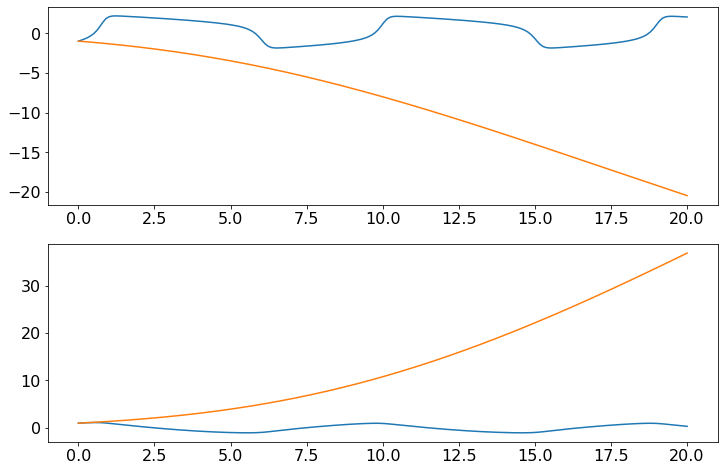

In [72]:
ax1 = plt.subplot(211)
plt.plot(t_space, true_soln[:,0])
plt.plot(t_space, pred_soln[:,0])

ax2 = plt.subplot(212, sharex=ax1)
plt.plot(t_space, true_soln[:,1])
plt.plot(t_space, pred_soln[:,1])
plt.show()

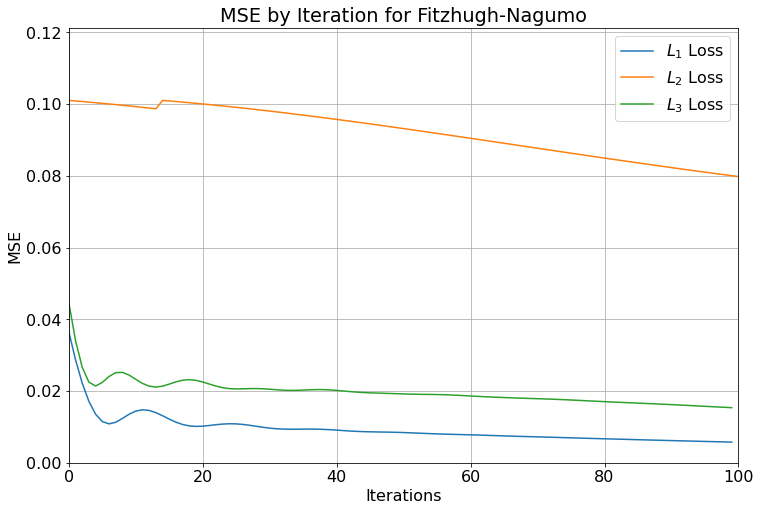

In [87]:
max_val = max([max(loss_vec_fn_l1), max(loss_vec_fn_l2), max(loss_vec_fn_l3)])

fig, ax = plt.subplots(1,1)
ax.plot(range(len(loss_vec_fn_l1)), loss_vec_fn_l1, label='$L_1$ Loss')
ax.plot(range(len(loss_vec_fn_l2)), loss_vec_fn_l2, label='$L_2$ Loss')
ax.plot(range(len(loss_vec_fn_l3)), loss_vec_fn_l3, label='$L_3$ Loss')
ax.set_xlabel('Iterations')
ax.set_ylabel('MSE')
ax.set_title('MSE by Iteration for Fitzhugh-Nagumo')
ax.set_xlim((0, len(loss_vec_fn_l1)))
ax.set_ylim((0, max_val * 1.2))
ax.legend(loc='best')
plt.grid()
plt.show()

## Lorenz

In [84]:
eta_method = 'random'
check_grads = False
max_it = 100

N = 200
ub = 20
n_dim = 3
m_basis_fns = 2

x0 = torch.tensor([8.0, 0.0, 30.0]).to(device)
x0.requires_grad_()
t_space = torch.linspace(0, ub, N).to(device)

tol = 10**-5


if eta_method == 'random':
    eta0 = torch.tensor(np.random.normal(0, 0.001, (n_dim,m_basis_fns)), dtype=torch.float).to(device)
elif eta_method == 'zeros':
    eta0 = torch.tensor(np.zeros((n_dim,m_basis_fns)), dtype=torch.float).to(device)
elif eta_method == 'actual':
    eta0 = torch.tensor(np.array([[0, 0.003], [0, 0], [0.005, 0]]), dtype=torch.float).to(device)
else:
    raise ValueError('You are trying to set eta in a way that is not supported. Check eta_method.')

with torch.no_grad():
    true_eta = torch.tensor([[0, 0.003], [0, 0], [0.005, 0]], dtype=torch.float)
    true_l63 = lambda t, x : L63_torch_modified(t, x, true_eta)
    true_soln = odeint(true_l63, x0, t_space)
    true_diff = torch.diff(true_soln, axis=0)


optlor = OptimizeLorenz(x0, t_space, 2, eta0=eta0).to(device)
optimizer = torch.optim.Adam([optlor.eta], lr=10**-5)
loss = torch.nn.MSELoss().to(device)

print('eta_0 = \n{}\n'.format(optlor.eta.detach().numpy()))

loss_vec_lor_l1 = []
eta_log = []

np.set_printoptions(precision=4)
for it in range(max_it):

    optimizer.zero_grad()

    pred_soln = odeint(optlor, x0, t_space).to(device)

    loss_curr = loss(pred_soln, true_soln)
    loss_curr.retain_grad()
    loss_curr.backward()

    print('Iterarion {}'.format(it+1))
    print('eta = \n{}'.format(optlor.eta.detach().numpy()))
    eta_log.append(optlor.eta.detach().numpy())
    print('loss = {:.4f}\n\n'.format(loss_curr))

    err = loss_curr.detach().numpy()
    loss_vec_lor_l1.append(err)

    optimizer.step()

eta_0 = 
[[ 1.3448e-04 -5.9530e-04]
 [ 1.1447e-03 -2.0886e-03]
 [-9.0089e-07  1.6523e-03]]

Iterarion 1
eta = 
[[ 1.3448e-04 -5.9530e-04]
 [ 1.1447e-03 -2.0886e-03]
 [-9.0089e-07  1.6523e-03]]
loss = 54.1754


Iterarion 2
eta = 
[[ 1.4448e-04 -5.8530e-04]
 [ 1.1547e-03 -2.0786e-03]
 [-1.0901e-05  1.6623e-03]]
loss = 63.2345


Iterarion 3
eta = 
[[ 1.3708e-04 -5.9270e-04]
 [ 1.1473e-03 -2.0860e-03]
 [-3.5006e-06  1.6549e-03]]
loss = 88.6543


Iterarion 4
eta = 
[[ 1.2866e-04 -6.0111e-04]
 [ 1.1389e-03 -2.0944e-03]
 [ 4.9157e-06  1.6465e-03]]
loss = 86.0408


Iterarion 5
eta = 
[[ 1.2057e-04 -6.0920e-04]
 [ 1.1308e-03 -2.1025e-03]
 [ 1.2998e-05  1.6384e-03]]
loss = 91.1411


Iterarion 6
eta = 
[[ 1.1362e-04 -6.1614e-04]
 [ 1.1238e-03 -2.1094e-03]
 [ 1.9941e-05  1.6314e-03]]
loss = 91.2498


Iterarion 7
eta = 
[[ 1.0812e-04 -6.2165e-04]
 [ 1.1183e-03 -2.1149e-03]
 [ 2.5450e-05  1.6259e-03]]
loss = 103.1242


Iterarion 8
eta = 
[[ 1.0600e-04 -6.2378e-04]
 [ 1.1162e-03 -2.1170e-03]
 [ 2.758

Iterarion 70
eta = 
[[ 1.9512e-04 -5.3474e-04]
 [ 1.2053e-03 -2.0280e-03]
 [-6.1441e-05  1.7129e-03]]
loss = 96.9155


Iterarion 71
eta = 
[[ 1.9873e-04 -5.3113e-04]
 [ 1.2089e-03 -2.0244e-03]
 [-6.5057e-05  1.7165e-03]]
loss = 95.0656


Iterarion 72
eta = 
[[ 2.0205e-04 -5.2780e-04]
 [ 1.2123e-03 -2.0211e-03]
 [-6.8379e-05  1.7198e-03]]
loss = 102.2205


Iterarion 73
eta = 
[[ 2.0082e-04 -5.2906e-04]
 [ 1.2110e-03 -2.0223e-03]
 [-6.7110e-05  1.7186e-03]]
loss = 95.4662


Iterarion 74
eta = 
[[ 1.9925e-04 -5.3066e-04]
 [ 1.2094e-03 -2.0239e-03]
 [-6.5503e-05  1.7170e-03]]
loss = 98.7300


Iterarion 75
eta = 
[[ 1.9792e-04 -5.3202e-04]
 [ 1.2081e-03 -2.0253e-03]
 [-6.4138e-05  1.7157e-03]]
loss = 91.0876


Iterarion 76
eta = 
[[ 1.9668e-04 -5.3328e-04]
 [ 1.2069e-03 -2.0266e-03]
 [-6.2864e-05  1.7144e-03]]
loss = 98.1376


Iterarion 77
eta = 
[[ 1.9564e-04 -5.3435e-04]
 [ 1.2058e-03 -2.0276e-03]
 [-6.1791e-05  1.7134e-03]]
loss = 96.6866


Iterarion 78
eta = 
[[ 1.9426e-04 -5.3575e-04]


In [86]:
eta_method = 'random'
check_grads = False
max_it = 100

N = 200
ub = 20
n_dim = 3
m_basis_fns = 2

x0 = torch.tensor([8.0, 0.0, 30.0]).to(device)
x0.requires_grad_()
t_space = torch.linspace(0, ub, N).to(device)

tol = 10**-5


if eta_method == 'random':
    eta0 = torch.tensor(np.random.normal(0, 0.001, (n_dim,m_basis_fns)), dtype=torch.float).to(device)
elif eta_method == 'zeros':
    eta0 = torch.tensor(np.zeros((n_dim,m_basis_fns)), dtype=torch.float).to(device)
elif eta_method == 'actual':
    eta0 = torch.tensor(np.array([[0, 0.003], [0, 0], [0.005, 0]]), dtype=torch.float).to(device)
else:
    raise ValueError('You are trying to set eta in a way that is not supported. Check eta_method.')

with torch.no_grad():
    true_eta = torch.tensor([[0, 0.003], [0, 0], [0.005, 0]], dtype=torch.float)
    true_l63 = lambda t, x : L63_torch_modified(t, x, true_eta)
    true_soln = odeint(true_l63, x0, t_space)
    true_diff = torch.diff(true_soln, axis=0)


optlor = OptimizeLorenz(x0, t_space, 2, eta0=eta0).to(device)
optimizer = torch.optim.Adam([optlor.eta], lr=10**-5)
# loss = torch.nn.MSELoss().to(device)
loss = DiffLoss().to(device)

print('eta_0 = \n{}\n'.format(optlor.eta.detach().numpy()))

loss_vec_lor_l3 = []
eta_log = []

np.set_printoptions(precision=4)
for it in range(max_it):

    optimizer.zero_grad()

    pred_soln = odeint(optlor, x0, t_space).to(device)

    loss_curr = loss(pred_soln, true_soln)
    loss_curr.retain_grad()
    loss_curr.backward()

    print('Iterarion {}'.format(it+1))
    print('eta = \n{}'.format(optlor.eta.detach().numpy()))
    eta_log.append(optlor.eta.detach().numpy())
    print('loss = {:.4f}\n\n'.format(loss_curr))

    err = np.sum((pred_soln.detach().numpy() - true_soln.detach().numpy())**2) / N
    loss_vec_lor_l3.append(err)

    optimizer.step()

eta_0 = 
[[-0.0017  0.0004]
 [ 0.0021 -0.0005]
 [-0.0004  0.0009]]

Iterarion 1
eta = 
[[-0.0017  0.0004]
 [ 0.0021 -0.0005]
 [-0.0004  0.0009]]
loss = 56.3018


Iterarion 2
eta = 
[[-0.0017  0.0004]
 [ 0.0021 -0.0005]
 [-0.0004  0.0009]]
loss = 50.3406


Iterarion 3
eta = 
[[-0.0017  0.0004]
 [ 0.0021 -0.0005]
 [-0.0004  0.0009]]
loss = 49.9482


Iterarion 4
eta = 
[[-0.0017  0.0004]
 [ 0.0021 -0.0005]
 [-0.0004  0.0009]]
loss = 56.5120


Iterarion 5
eta = 
[[-0.0018  0.0004]
 [ 0.0021 -0.0005]
 [-0.0004  0.0009]]
loss = 54.5280


Iterarion 6
eta = 
[[-0.0018  0.0004]
 [ 0.0021 -0.0005]
 [-0.0004  0.0009]]
loss = 58.6268


Iterarion 7
eta = 
[[-0.0018  0.0004]
 [ 0.0021 -0.0005]
 [-0.0004  0.0009]]
loss = 43.1675


Iterarion 8
eta = 
[[-0.0018  0.0004]
 [ 0.0021 -0.0006]
 [-0.0004  0.0009]]
loss = 50.0455


Iterarion 9
eta = 
[[-0.0018  0.0004]
 [ 0.0021 -0.0006]
 [-0.0004  0.0009]]
loss = 51.1880


Iterarion 10
eta = 
[[-0.0018  0.0004]
 [ 0.0021 -0.0005]
 [-0.0004  0.0009]]
loss = 5

Iterarion 87
eta = 
[[-0.0016  0.0005]
 [ 0.0022 -0.0004]
 [-0.0005  0.001 ]]
loss = 41.7466


Iterarion 88
eta = 
[[-0.0016  0.0005]
 [ 0.0022 -0.0004]
 [-0.0005  0.001 ]]
loss = 39.5807


Iterarion 89
eta = 
[[-0.0016  0.0005]
 [ 0.0022 -0.0004]
 [-0.0005  0.001 ]]
loss = 35.4044


Iterarion 90
eta = 
[[-0.0016  0.0005]
 [ 0.0022 -0.0004]
 [-0.0005  0.001 ]]
loss = 45.6764


Iterarion 91
eta = 
[[-0.0016  0.0005]
 [ 0.0022 -0.0004]
 [-0.0005  0.001 ]]
loss = 42.5016


Iterarion 92
eta = 
[[-0.0016  0.0005]
 [ 0.0022 -0.0004]
 [-0.0005  0.001 ]]
loss = 47.9692


Iterarion 93
eta = 
[[-0.0016  0.0005]
 [ 0.0022 -0.0004]
 [-0.0005  0.001 ]]
loss = 47.9084


Iterarion 94
eta = 
[[-0.0016  0.0005]
 [ 0.0022 -0.0004]
 [-0.0005  0.001 ]]
loss = 47.6679


Iterarion 95
eta = 
[[-0.0016  0.0005]
 [ 0.0022 -0.0004]
 [-0.0005  0.001 ]]
loss = 42.5187


Iterarion 96
eta = 
[[-0.0016  0.0005]
 [ 0.0022 -0.0004]
 [-0.0005  0.001 ]]
loss = 49.1108


Iterarion 97
eta = 
[[-0.0016  0.0005]
 [ 0.0022 -

In [97]:
eta_method = 'random'
check_grads = False
max_it = 100

N = 200
ub = 20
n_dim = 3
m_basis_fns = 2

x0 = torch.tensor([8.0, 0.0, 30.0]).to(device)
x0.requires_grad_()
t_space = torch.linspace(0, ub, N).to(device)

tol = 10**-5


if eta_method == 'random':
    eta0 = torch.tensor(np.random.normal(0, 0.001, (n_dim,m_basis_fns)), dtype=torch.float).to(device)
elif eta_method == 'zeros':
    eta0 = torch.tensor(np.zeros((n_dim,m_basis_fns)), dtype=torch.float).to(device)
elif eta_method == 'actual':
    eta0 = torch.tensor(np.array([[0, 0.003], [0, 0], [0.005, 0]]), dtype=torch.float).to(device)
else:
    raise ValueError('You are trying to set eta in a way that is not supported. Check eta_method.')

with torch.no_grad():
    true_eta = torch.tensor([[0, 0.003], [0, 0], [0.005, 0]], dtype=torch.float)
    true_l63 = lambda t, x : L63_torch_modified(t, x, true_eta)
    true_soln = odeint(true_l63, x0, t_space)
    true_diff = torch.diff(true_soln, axis=0)


optlor = OptimizeLorenzVector(x0, t_space, 2, eta0=eta0).to(device)
optimizer = torch.optim.Adam([optlor.eta], lr=10**-5)
loss = torch.nn.MSELoss().to(device)

print('eta_0 = \n{}\n'.format(optlor.eta.detach().numpy()))

loss_vec_lor_l2 = []
eta_log_lor_l2 = []

np.set_printoptions(precision=4)
for it in range(max_it):

    optimizer.zero_grad()

#     pred_soln = odeint(optlor, x0, t_space).to(device)
    pred_diff = make_predictions(t_space, true_soln, optlor).to(device)

    loss_curr = loss(pred_diff, true_diff)
    loss_curr.retain_grad()
    loss_curr.backward()

    print('Iterarion {}'.format(it+1))
    print('eta = \n{}'.format(optlor.eta.detach().numpy()))
    eta_log_lor_l2.append(optlor.eta.detach().numpy().copy())
    print('loss = {:.4f}\n\n'.format(loss_curr))

    optimizer.step()

eta_0 = 
[[-0.0003 -0.0004]
 [ 0.0007 -0.0004]
 [-0.0012 -0.0009]]

Iterarion 1
eta = 
[[-0.0003 -0.0004]
 [ 0.0007 -0.0004]
 [-0.0012 -0.0009]]
loss = 3556.4548


Iterarion 2
eta = 
[[-0.0003 -0.0004]
 [ 0.0007 -0.0004]
 [-0.0012 -0.0009]]
loss = 3556.3789


Iterarion 3
eta = 
[[-0.0003 -0.0004]
 [ 0.0007 -0.0004]
 [-0.0012 -0.0009]]
loss = 3556.3032


Iterarion 4
eta = 
[[-0.0003 -0.0003]
 [ 0.0007 -0.0004]
 [-0.0012 -0.0009]]
loss = 3556.2278


Iterarion 5
eta = 
[[-0.0004 -0.0003]
 [ 0.0007 -0.0004]
 [-0.0012 -0.001 ]]
loss = 3556.1521


Iterarion 6
eta = 
[[-0.0004 -0.0003]
 [ 0.0007 -0.0004]
 [-0.0012 -0.001 ]]
loss = 3556.0767


Iterarion 7
eta = 
[[-0.0004 -0.0003]
 [ 0.0008 -0.0004]
 [-0.0013 -0.001 ]]
loss = 3556.0007


Iterarion 8
eta = 
[[-0.0004 -0.0003]
 [ 0.0008 -0.0004]
 [-0.0013 -0.001 ]]
loss = 3555.9250


Iterarion 9
eta = 
[[-0.0004 -0.0003]
 [ 0.0008 -0.0003]
 [-0.0013 -0.001 ]]
loss = 3555.8494


Iterarion 10
eta = 
[[-0.0004 -0.0003]
 [ 0.0008 -0.0003]
 [-0.0013 

In [98]:
optlor_test = OptimizeLorenz(x0, t_space, 2, eta0)

for i in range(100):
    eta = eta_log_lor_l2[i]
    optlor_test.eta = torch.tensor(eta).detach()
    pred_soln = odeint(optlor_test, x0, t_space).detach().numpy()
    err = np.sum((pred_soln - true_soln.detach().numpy())**2) / N
    loss_vec_lor_l2.append(err)
    print(eta)
    print(i)

[[-0.0003 -0.0004]
 [ 0.0007 -0.0004]
 [-0.0012 -0.0009]]
0
[[-0.0003 -0.0004]
 [ 0.0007 -0.0004]
 [-0.0012 -0.0009]]
1
[[-0.0003 -0.0004]
 [ 0.0007 -0.0004]
 [-0.0012 -0.0009]]
2
[[-0.0003 -0.0003]
 [ 0.0007 -0.0004]
 [-0.0012 -0.0009]]
3
[[-0.0004 -0.0003]
 [ 0.0007 -0.0004]
 [-0.0012 -0.001 ]]
4
[[-0.0004 -0.0003]
 [ 0.0007 -0.0004]
 [-0.0012 -0.001 ]]
5
[[-0.0004 -0.0003]
 [ 0.0008 -0.0004]
 [-0.0013 -0.001 ]]
6
[[-0.0004 -0.0003]
 [ 0.0008 -0.0004]
 [-0.0013 -0.001 ]]
7
[[-0.0004 -0.0003]
 [ 0.0008 -0.0003]
 [-0.0013 -0.001 ]]
8
[[-0.0004 -0.0003]
 [ 0.0008 -0.0003]
 [-0.0013 -0.001 ]]
9
[[-0.0004 -0.0003]
 [ 0.0008 -0.0003]
 [-0.0013 -0.001 ]]
10
[[-0.0004 -0.0003]
 [ 0.0008 -0.0003]
 [-0.0013 -0.001 ]]
11
[[-0.0004 -0.0003]
 [ 0.0008 -0.0003]
 [-0.0013 -0.001 ]]
12
[[-0.0004 -0.0003]
 [ 0.0008 -0.0003]
 [-0.0013 -0.001 ]]
13
[[-0.0005 -0.0002]
 [ 0.0008 -0.0003]
 [-0.0013 -0.0011]]
14
[[-0.0005 -0.0002]
 [ 0.0008 -0.0003]
 [-0.0013 -0.0011]]
15
[[-0.0005 -0.0002]
 [ 0.0009 -0.00

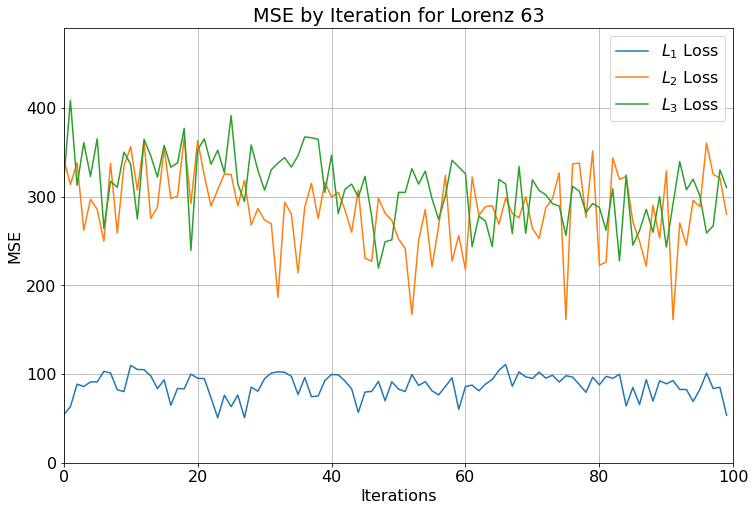

In [99]:
max_val = max([max(loss_vec_lor_l1), max(loss_vec_lor_l2), max(loss_vec_lor_l3)])

fig, ax = plt.subplots(1,1)
ax.plot(range(len(loss_vec_lor_l1)), loss_vec_lor_l1, label='$L_1$ Loss')
ax.plot(range(len(loss_vec_lor_l2)), loss_vec_lor_l2, label='$L_2$ Loss')
ax.plot(range(len(loss_vec_lor_l3)), loss_vec_lor_l3, label='$L_3$ Loss')
ax.set_xlabel('Iterations')
ax.set_ylabel('MSE')
ax.set_title('MSE by Iteration for Lorenz 63')
ax.set_xlim((0, len(loss_vec_lor_l1)))
ax.set_ylim((0, max_val * 1.2))
ax.legend(loc='best')
plt.grid()
plt.show()